## BERT 구현 과정 (2/2)
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2020-01-02/bert-classification.png)

BERT 모델 구현에 대한 설명 입니다.

이 내용을 확인하기 전 아래 내용을 확인하시기 바랍니다.
- [Sentencepiece를 활용해 Vocab 만들기](https://paul-hyun.github.io/vocab-with-sentencepiece/)
- [Naver 영화리뷰 감정분석 데이터 전처리 하기](https://paul-hyun.github.io/preprocess-nsmc/)
- [Transformer (Attention Is All You Need) 구현하기 (1/3)](https://paul-hyun.github.io/transformer-01/)
- [Transformer (Attention Is All You Need) 구현하기 (2/3)](https://paul-hyun.github.io/transformer-02/)
- [Transformer (Attention Is All You Need) 구현하기 (3/3)](https://paul-hyun.github.io/transformer-03/)
- [BERT(Bidirectional Encoder Representations from Transformers) 구현하기 (1/2)](https://paul-hyun.github.io/bert-01/)

[Colab](https://colab.research.google.com/)에서 실행 했습니다.

#### 0. Pip Install
필요한 패키지를 pip를 이용해서 설치합니다.

In [1]:
!pip install sentencepiece
!pip install wget

     |████████████████████████████████| 1.0MB 3.5MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=fbe3e0ed3f7e6c70494e79fc604efd380b7d12ea3279369dae9a5ac2c3c923e8
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


#### 1. Google Drive Mount
Colab에서는 컴퓨터에 자원에 접근이 불가능 하므로 Google Drive에 파일을 올려 놓은 후 Google Drive를 mount 에서 로컬 디스크처럼 사용 합니다.
1. 아래 블럭을 실행하면 나타나는 링크를 클릭하세요.
2. Google 계정을 선택 하시고 허용을 누르면 나타나는 코드를 복사하여 아래 박스에 입력한 후 Enter 키를 입력하면 됩니다.

학습관련 [데이터 및 결과 파일](https://drive.google.com/open?id=15XGr-L-W6DSoR5TbniPMJASPsA0IDTiN)을 참고 하세요.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# data를 저장할 폴더 입니다. 환경에 맞게 수정 하세요.
data_dir = "/content/drive/My Drive/Data/transformer-evolution"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### 2. Imports

In [0]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

#### 3. 폴더의 목록을 확인
Google Drive mount가 잘 되었는지 확인하기 위해 data_dir 목록을 확인 합니다.

In [0]:
for f in os.listdir(data_dir):
  print(f)

kowiki.csv.gz
kowiki.model
kowiki.vocab
ratings_train.txt
ratings_test.txt
ratings_train.json
ratings_test.json
kowiki.txt
kowiki_gpt.json
save_gpt_pretrain.pth
kowiki_bert_0.json
save_bert_pretrain.pth


#### 4. Vocab 및 입력

[Sentencepiece를 활용해 Vocab 만들기](https://paul-hyun.github.io/vocab-with-sentencepiece/)를 통해 만들어 놓은 vocab을 로딩 합니다.

In [4]:
# vocab loading
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

#### 5. Config

모델에 설정 값을 전달하기 위한 config를 만듭니다.

In [0]:
""" configuration json을 읽어들이는 class """
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [6]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_seg_type": 2,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


#### 6. BERT

BERT Class 및 함수 입니다.

In [0]:
""" sinusoid position encoding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table


""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)  # <pad>
    return pad_attn_mask


""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob


""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob


""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

In [0]:
""" encoder layer """
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob


""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        self.pos_emb = nn.Embedding(self.config.n_enc_seq + 1, self.config.d_hidn)
        self.seg_emb = nn.Embedding(self.config.n_seg_type, self.config.d_hidn)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs, segments):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)  + self.seg_emb(segments)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs


""" bert """
class BERT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)

        self.linear = nn.Linear(config.d_hidn, config.d_hidn)
        self.activation = torch.tanh
    
    def forward(self, inputs, segments):
        # (bs, n_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        outputs, self_attn_probs = self.encoder(inputs, segments)
        # (bs, d_hidn)
        outputs_cls = outputs[:, 0].contiguous()
        outputs_cls = self.linear(outputs_cls)
        outputs_cls = self.activation(outputs_cls)
        # (bs, n_enc_seq, n_enc_vocab), (bs, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, outputs_cls, self_attn_probs
    
    def save(self, epoch, loss, path):
        torch.save({
            "epoch": epoch,
            "loss": loss,
            "state_dict": self.state_dict()
        }, path)
    
    def load(self, path):
        save = torch.load(path)
        self.load_state_dict(save["state_dict"])
        return save["epoch"], save["loss"]

#### 7. Naver 영화 분류 모델

In [0]:
""" naver movie classfication """
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.bert = BERT(self.config)
        # classfier
        self.projection_cls = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, inputs, segments):
        # (bs, n_enc_seq, d_hidn), (bs, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        outputs, outputs_cls, attn_probs = self.bert(inputs, segments)
        # (bs, n_output)
        logits_cls = self.projection_cls(outputs_cls)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return logits_cls, attn_probs

#### 8. 네이버 영화 분류 데이터

In [0]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []
        self.segments = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc="Loading Dataset", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                sentence = [vocab.piece_to_id("[CLS]")] + [vocab.piece_to_id(p) for p in data["doc"]] + [vocab.piece_to_id("[SEP]")]
                self.sentences.append(sentence)
                self.segments.append([0] * len(sentence))
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        assert len(self.labels) == len(self.segments)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor(self.segments[item]))

In [0]:
""" movie data collate_fn """
def movie_collate_fn(inputs):
    labels, inputs, segments = list(zip(*inputs))

    inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
    segments = torch.nn.utils.rnn.pad_sequence(segments, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        inputs,
        segments,
    ]
    return batch

In [12]:
""" 데이터 로더 """
batch_size = 128
train_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading Dataset: 100%|██████████| 49997/49997 [00:01<00:00, 28653.14 lines/s]


#### 9. 네이버 영화 분류 데이터 학습

In [0]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, inputs, segments = map(lambda v: v.to(config.device), value)

            outputs = model(inputs, segments)
            logits_cls = outputs[0]
            _, indices = logits_cls.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

In [0]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion_cls, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
        for i, value in enumerate(train_loader):
            labels, inputs, segments = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(inputs, segments)
            logits_cls = outputs[0]

            loss_cls = criterion_cls(logits_cls, labels)
            loss = loss_cls

            loss_val = loss_cls.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [15]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 2}


In [0]:
def train(model):
    model.to(config.device)

    criterion_cls = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_epoch, best_loss, best_score = 0, 0, 0
    losses, scores = [], []
    for epoch in range(n_epoch):
        loss = train_epoch(config, epoch, model, criterion_cls, optimizer, train_loader)
        score = eval_epoch(config, model, test_loader)

        losses.append(loss)
        scores.append(score)

        if best_score < score:
            best_epoch, best_loss, best_score = epoch, loss, score
    print(f">>>> epoch={best_epoch}, loss={best_loss:.5f}, socre={best_score:.5f}")
    return losses, scores

###### Pretrain 없이 학습

In [18]:
model = MovieClassification(config)

losses_00, scores_00 = train(model)

Valid: 100%|██████████| 391/391 [00:49<00:00,  5.33it/s, Acc: 0.818]


>>>> epoch=9, loss=0.28937, socre=0.81795


###### Pretrain을 한 후 학습

In [19]:
model = MovieClassification(config)

save_pretrain = f"{data_dir}/save_bert_pretrain.pth"
model.bert.load(save_pretrain)

losses_20, scores_20 = train(model)

Valid: 100%|██████████| 391/391 [00:50<00:00,  5.20it/s, Acc: 0.818]


>>>> epoch=7, loss=0.31119, socre=0.82397


#### 10. Result

,loss_00,socre_00,loss_20,socre_20
0,0.522093,0.783687,0.515065,0.782307
1,0.436096,0.795608,0.434717,0.798528
2,0.408585,0.804388,0.405332,0.809989
3,0.388935,0.810749,0.383013,0.814149
4,0.371047,0.813969,0.364083,0.816289
5,0.355533,0.810529,0.347914,0.817629
6,0.341048,0.815309,0.329771,0.820329
7,0.324362,0.813649,0.311193,0.823969
8,0.307140,0.816129,0.295256,0.822689
9,0.289369,0.817949,0.276582,0.818469


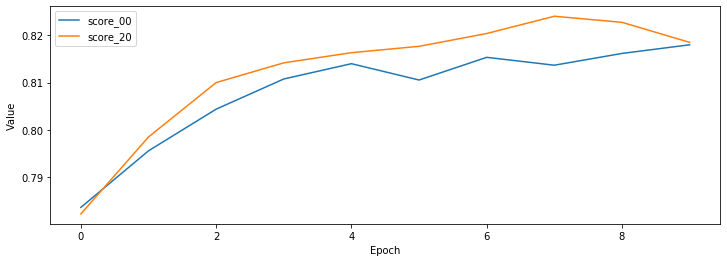

In [20]:
# table
data = {
    "loss_00": losses_00,
    "socre_00": scores_00,
    "loss_20": losses_20,
    "socre_20": scores_20,
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(scores_00, label="score_00")
plt.plot(scores_20, label="score_20")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()